In [1]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [2]:
!pip install nltk
!pip install textblob
!pip install wordcloud

In [3]:
df = pd.read_csv("amazon_reviews.csv", sep=",")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [4]:
df['reviewText']   #Burada bazı harfler büyük bazıları küçük. Bunu normalize etmemiz lazım. Hepsini küçük harflere çevirelim

,reviewText
0,No issues.
1,"Purchased this for my device, it worked as adv..."
2,it works as expected. I should have sprung for...
3,This think has worked out great.Had a diff. br...
4,"Bought it with Retail Packaging, arrived legit..."
...,...
4910,I bought this Sandisk 16GB Class 10 to use wit...
4911,Used this for extending the capabilities of my...
4912,Great card that is very fast and reliable. It ...
4913,Good amount of space for the stuff I want to d...


In [5]:
df['reviewText']=df['reviewText'].str.lower()
df['reviewText']

,reviewText
0,no issues.
1,"purchased this for my device, it worked as adv..."
2,it works as expected. i should have sprung for...
3,this think has worked out great.had a diff. br...
4,"bought it with retail packaging, arrived legit..."
...,...
4910,i bought this sandisk 16gb class 10 to use wit...
4911,used this for extending the capabilities of my...
4912,great card that is very fast and reliable. it ...
4913,good amount of space for the stuff i want to d...


In [6]:
df['reviewText'] = df['reviewText'].str.replace(r'[^\w\s]', '', regex=True)  #regular expression
df['reviewText']
#\w: Harf, rakam veya alt çizgi (a-z, A-Z, 0-9, _)
#\s: Boşluk karakterleri (boşluk, tab, yeni satır)
#^: Olumsuzlama operatörüdür. Yani "\w VEYA \s OLMAYAN" karakterleri ifade eder. Bunları siler...

,reviewText
0,no issues
1,purchased this for my device it worked as adve...
2,it works as expected i should have sprung for ...
3,this think has worked out greathad a diff bran...
4,bought it with retail packaging arrived legit ...
...,...
4910,i bought this sandisk 16gb class 10 to use wit...
4911,used this for extending the capabilities of my...
4912,great card that is very fast and reliable it c...
4913,good amount of space for the stuff i want to d...


In [7]:
df['reviewText'] = df['reviewText'].str.replace(r'\d+', '', regex=True)   #sayıları silme
df['reviewText']

,reviewText
0,no issues
1,purchased this for my device it worked as adve...
2,it works as expected i should have sprung for ...
3,this think has worked out greathad a diff bran...
4,bought it with retail packaging arrived legit ...
...,...
4910,i bought this sandisk gb class to use with my...
4911,used this for extending the capabilities of my...
4912,great card that is very fast and reliable it c...
4913,good amount of space for the stuff i want to d...


In [8]:
import nltk
nltk.download('stopwords')        #stopwords
print("stopwords")

stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from nltk.corpus import stopwords
turkish_stopwords = stopwords.words('turkish')   #Türkçe'deki stopwords'ler
print(turkish_stopwords)

['acaba', 'ama', 'aslında', 'az', 'bazı', 'belki', 'biri', 'birkaç', 'birşey', 'biz', 'bu', 'çok', 'çünkü', 'da', 'daha', 'de', 'defa', 'diye', 'eğer', 'en', 'gibi', 'hem', 'hep', 'hepsi', 'her', 'hiç', 'için', 'ile', 'ise', 'kez', 'ki', 'kim', 'mı', 'mu', 'mü', 'nasıl', 'ne', 'neden', 'nerde', 'nerede', 'nereye', 'niçin', 'niye', 'o', 'sanki', 'şey', 'siz', 'şu', 'tüm', 've', 'veya', 'ya', 'yani']


In [10]:
sw=stopwords.words('english')
sw

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [11]:
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df['reviewText']   #stopwords'leri silme

,reviewText
0,issues
1,purchased device worked advertised never much ...
2,works expected sprung higher capacity think ma...
3,think worked greathad diff bran gb card went s...
4,bought retail packaging arrived legit orange e...
...,...
4910,bought sandisk gb class use htc inspire months...
4911,used extending capabilities samsung galaxy not...
4912,great card fast reliable comes optional adapte...
4913,good amount space stuff want fits gopro say


In [12]:
temp_df = pd.Series(' '.join(df['reviewText']).split()).value_counts() #Rarewords(nadir kelimeler)
temp_df

,count
card,4603
gb,1725
phone,1685
works,1559
great,1445
...,...
brag,1
tradeoff,1
timeyour,1
advancing,1


In [13]:
drops = temp_df[temp_df <= 1]  #1 ve daha az kullanılan kelimeleri drops'a aktardım. Altta bunu '' ile değiştirdim, yani sildim
drops

df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))
df['reviewText']          #Az frekansa sahip olan kelimelerden de kurtuldum

,reviewText
0,issues
1,purchased device worked advertised never much ...
2,works expected higher capacity think made bit ...
3,think worked gb card went south one held prett...
4,bought retail packaging arrived legit envelope...
...,...
4910,bought sandisk gb class use htc inspire months...
4911,used capabilities samsung galaxy note greatly ...
4912,great card fast reliable comes optional adapte...
4913,good amount space stuff want fits gopro say


In [14]:
import nltk
nltk.download('punkt_tab')
#Tokenization: Cümleleri birimleştirme
df["reviewText"].apply(lambda x: TextBlob(x).words).head()
#Bu satırın amacı, reviewText sütunundaki her bir yorumu kelimelere ayırmak.

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,reviewText
0,[issues]
1,"[purchased, device, worked, advertised, never,..."
2,"[works, expected, higher, capacity, think, mad..."
3,"[think, worked, gb, card, went, south, one, he..."
4,"[bought, retail, packaging, arrived, legit, en..."


In [15]:
import nltk                      #Örnek Türkçe Tokenization
nltk.download("punkt")
from nltk.tokenize import sent_tokenize, word_tokenize

# Türkçe tokenleştirme için 'punkt_tab' kaynağını indirin
nltk.download('punkt_tab')

# Artık sent_tokenize'ı language="turkish" ile kullanabilirsiniz
metin = "Merhaba dünya. Nasılsın? Ben iyiyim Allah razı olsun..."
cumleler = sent_tokenize(metin, language="turkish")
kelimeler = word_tokenize(metin, language="turkish")

print(cumleler)  # ['Merhaba dünya.', 'Nasılsın?']
print(kelimeler)  # ['Merhaba', 'dünya', '.', 'Nasılsın', '?']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


['Merhaba dünya.', 'Nasılsın?', 'Ben iyiyim Allah razı olsun...']
['Merhaba', 'dünya', '.', 'Nasılsın', '?', 'Ben', 'iyiyim', 'Allah', 'razı', 'olsun', '...']


In [16]:
import nltk
nltk.download('wordnet')
# Lemmatization(Kelimeleri köklerine ayırma)
# nltk.download('wordnet')

df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['reviewText']

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,reviewText
0,issue
1,purchased device worked advertised never much ...
2,work expected higher capacity think made bit e...
3,think worked gb card went south one held prett...
4,bought retail packaging arrived legit envelope...
...,...
4910,bought sandisk gb class use htc inspire month ...
4911,used capability samsung galaxy note greatly ex...
4912,great card fast reliable come optional adapter...
4913,good amount space stuff want fit gopro say


In [17]:
import nltk                      #Lemmatization
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize("running"))     # 'running' → 'running' (fiil olduğunu belirtmedik)
print(lemmatizer.lemmatize("running", pos='v'))

running
run


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
import nltk                    #Stemming
nltk.download('wordnet')
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

words = ["study", "studying", "studies", "studied"]

for word in words:
    print(f"{word} → {stemmer.stem(word)}")
#Hız, düşük kaynak, basitlik ---> stemming
#Anlam bütünlüğü, doğruluk önemliyse ---> Lemmatization

study → studi
studying → studi
studies → studi
studied → studi


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
#Kelime	         Stemming Sonucu	     Lemmatization Sonucu
#studying	        studi                  	study
#flies          	fli	                    fly
#better	          better                	good

# 2. Text Visualization(Veri Görselleştirme)

In [20]:
df["reviewText"]

,reviewText
0,issue
1,purchased device worked advertised never much ...
2,work expected higher capacity think made bit e...
3,think worked gb card went south one held prett...
4,bought retail packaging arrived legit envelope...
...,...
4910,bought sandisk gb class use htc inspire month ...
4911,used capability samsung galaxy note greatly ex...
4912,great card fast reliable come optional adapter...
4913,good amount space stuff want fit gopro say


In [21]:
# Terim Frekanslarının Hesaplanması

tf = df["reviewText"].apply(lambda x: pd.Series(x.split(" ")).value_counts()).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf = tf.sort_values("tf", ascending=False)
tf

,words,tf
27,card,5537.0
14,work,2044.0
7,phone,1909.0
28,gb,1756.0
91,great,1445.0
...,...,...
3653,recommemd,2.0
3652,nowhere,2.0
3651,ultrabook,2.0
3650,fluke,2.0


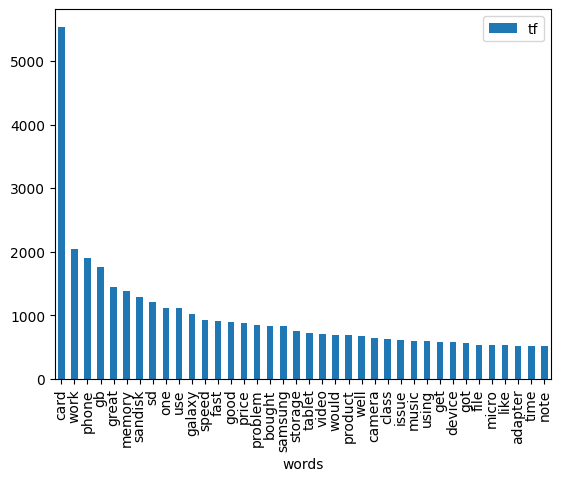

In [22]:
# Barplot(Sütun Grafiği)

tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

In [23]:
# Wordcloud(Kelime Bulutu)
text = " ".join(i for i in df.reviewText)    #tüm satırları tek bir metne çevirme
text

'issue purchased device worked advertised never much phone memory since download lot stuff brainer work expected higher capacity think made bit earlier version paint look clean think worked gb card went south one held pretty well since note update ive month zero issue since transferred note note card reliable bought retail packaging arrived legit envelope version asian like picture show arrived quickly bought retail packaging htc one lg optimus card working order probably best price youll get nice sd card mini storage doesnt anything else supposed purchased add additional storage microsoft surface pro tablet come gb supposed sandisk long standing reputation speaks phone never skip beat file transfer speedy corruption issue memory issue would expect sandisk brand great card precious file slightly cheaper piece crap lose everything spending extra couple buck trusted product go good qa hard believe affordable digital become gb device one quarter postage stamp would less generation picked 

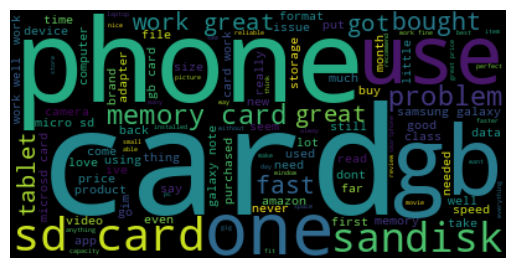

In [24]:
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

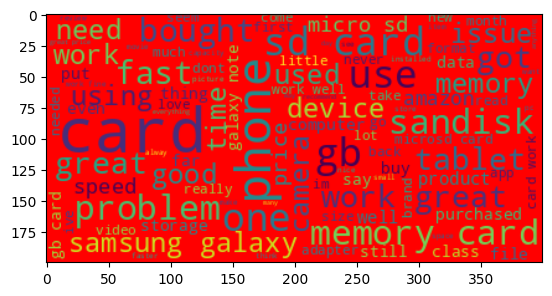

In [25]:
wordcloud = WordCloud(max_font_size=50,  #wordcloud'u biçimkendirme
                      max_words=100,
                      background_color="red").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("on")
plt.show()
wordcloud.to_file("wordcloud.png")   #wordcloud'u kaydetme. Çalışma dizinine kaydeder.

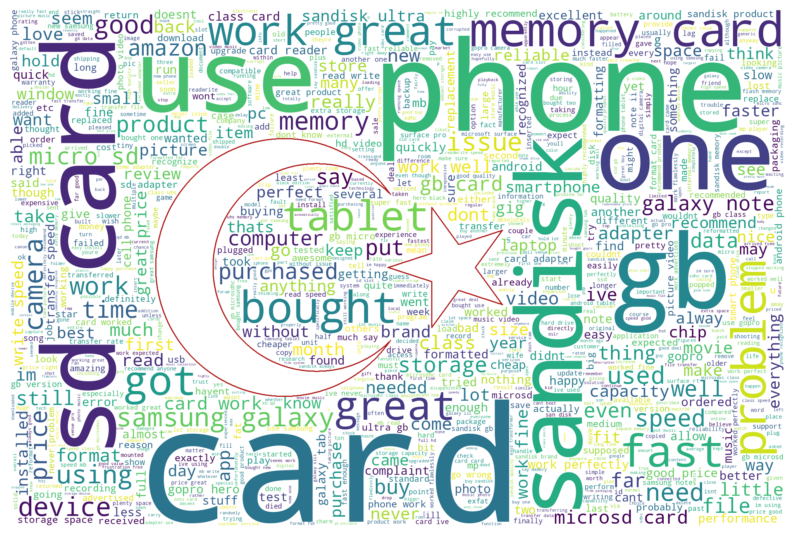

In [26]:
# Şablonlara Göre Wordcloud(Örneğin wp mesajlarına ait kelime bulutu da yapabilirdik...)

tr_mask = np.array(Image.open("tr.png"))

wc = WordCloud(background_color="white",
               max_words=1000,
               mask=tr_mask,
               contour_width=3,
               contour_color="firebrick")

wc.generate(text)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# 3. Sentiment Analysis

In [27]:
df["reviewText"].head()

,reviewText
0,issue
1,purchased device worked advertised never much ...
2,work expected higher capacity think made bit e...
3,think worked gb card went south one held prett...
4,bought retail packaging arrived legit envelope...


In [28]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
#Sentiment Analysis:Bir metnin pozitif/negatif olduğunu değerlendirir
df["reviewText"].head()

# nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
sia.polarity_scores("The film was awesome")
#neg	Metindeki olumsuz (negatif) duygu oranı → 0.0 → hiç olumsuz yok
#neu	Nötr kelime oranı → 0.423 → %42.3’ü nötr
#pos	Olumlu kelime oranı → 0.577 → %57.7’si olumlu
#compound	Genel duygu skoru (–1 ile +1 arası) → 0.6249 → oldukça olumlu

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [29]:
sia.polarity_scores("I liked this music but it is not good as the other one")

{'neg': 0.207, 'neu': 0.666, 'pos': 0.127, 'compound': -0.298}

In [30]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)) #Veri setimdeki ilk 10 satırın skorlarını çıkarttı

,reviewText
0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,"{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'comp..."
3,"{'neg': 0.0, 'neu': 0.798, 'pos': 0.202, 'comp..."
4,"{'neg': 0.0, 'neu': 0.747, 'pos': 0.253, 'comp..."
5,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
6,"{'neg': 0.108, 'neu': 0.598, 'pos': 0.295, 'co..."
7,"{'neg': 0.077, 'neu': 0.65, 'pos': 0.272, 'com..."
8,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
9,"{'neg': 0.0, 'neu': 0.457, 'pos': 0.543, 'comp..."


In [31]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"]) #compound'ların değerleri

,reviewText
0,0.0000
1,0.0000
2,0.4019
3,0.6486
4,0.8591
5,0.0000
6,0.8678
7,0.8221
8,0.0000
9,0.9167


In [32]:
df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])  #veri setimizde kalıcı hale getirdik
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.0,Four Stars,1406073600,2014-07-23,138,0,0,0.0000
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.0000
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0,0.4019
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked gb card went south one held prett...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.6486
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.0,best deal around,1373673600,2013-07-13,513,0,0,0.8591
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4910,A2LBMKXRM5H2W9,B007WTAJTO,"ZM ""J""","[0, 0]",bought sandisk gb class use htc inspire month ...,1.0,Do not waste your money.,1374537600,2013-07-23,503,0,0,0.0772
4911,ALGDLRUI1ZPCS,B007WTAJTO,Zo,"[0, 0]",used capability samsung galaxy note greatly ex...,5.0,Great item!,1377129600,2013-08-22,473,0,0,0.1761
4912,A2MR1NI0ENW2AD,B007WTAJTO,Z S Liske,"[0, 0]",great card fast reliable come optional adapter...,5.0,Fast and reliable memory card,1396224000,2014-03-31,252,0,0,0.8481
4913,A37E6P3DSO9QJD,B007WTAJTO,Z Taylor,"[0, 0]",good amount space stuff want fit gopro say,5.0,Great little card,1379289600,2013-09-16,448,0,0,0.6908


# 4. Feature Engineering

In [33]:
#sınıflandırma modeli(Belirli bir değerin üzerindekileri pozitif sınıf olarak işaretliyelim, belirli bir değerin altındakileri negatif sınıf olarak işaretleyelim ve böylece bir label oluşturalım. Daha sonra polarity_score yokmuş gibi davranarak bir snıflandırma problemi olarak ele almak)
df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")  #Değişkeni veri setimize ekledik(sentiment_label)
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score,sentiment_label
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.0,Four Stars,1406073600,2014-07-23,138,0,0,0.0000,neg
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.0000,neg
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0,0.4019,pos
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked gb card went south one held prett...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.6486,pos
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.0,best deal around,1373673600,2013-07-13,513,0,0,0.8591,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4910,A2LBMKXRM5H2W9,B007WTAJTO,"ZM ""J""","[0, 0]",bought sandisk gb class use htc inspire month ...,1.0,Do not waste your money.,1374537600,2013-07-23,503,0,0,0.0772,pos
4911,ALGDLRUI1ZPCS,B007WTAJTO,Zo,"[0, 0]",used capability samsung galaxy note greatly ex...,5.0,Great item!,1377129600,2013-08-22,473,0,0,0.1761,pos
4912,A2MR1NI0ENW2AD,B007WTAJTO,Z S Liske,"[0, 0]",great card fast reliable come optional adapter...,5.0,Fast and reliable memory card,1396224000,2014-03-31,252,0,0,0.8481,pos
4913,A37E6P3DSO9QJD,B007WTAJTO,Z Taylor,"[0, 0]",good amount space stuff want fit gopro say,5.0,Great little card,1379289600,2013-09-16,448,0,0,0.6908,pos


In [34]:
df["sentiment_label"].value_counts()

,count
sentiment_label,
pos,3944
neg,971


In [35]:
df.groupby("sentiment_label")["overall"].mean()

,overall
sentiment_label,
neg,4.094748
pos,4.708925


In [36]:
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])
df["sentiment_label"]  #makine öğrenmesi yöntemlerinin anlayacağı bir binary target future oluşturduk

,sentiment_label
0,0
1,0
2,1
3,1
4,1
...,...
4910,1
4911,1
4912,1
4913,1


In [37]:
y = df["sentiment_label"]  #bağımlı değişken
X = df["reviewText"]       #bağımsız değişken

In [38]:
y

,sentiment_label
0,0
1,0
2,1
3,1
4,1
...,...
4910,1
4911,1
4912,1
4913,1


In [39]:
X

,reviewText
0,issue
1,purchased device worked advertised never much ...
2,work expected higher capacity think made bit e...
3,think worked gb card went south one held prett...
4,bought retail packaging arrived legit envelope...
...,...
4910,bought sandisk gb class use htc inspire month ...
4911,used capability samsung galaxy note greatly ex...
4912,great card fast reliable come optional adapter...
4913,good amount space stuff want fit gopro say


In [40]:
# Matematiksel işlemlere sokulabilir olacak bazı future'lar türetmem lazım. reviewText metinlerden oluşmaktadır. Bunu ölçülebilir, matematiksel işlemler yapabileceğim formata getirmem lazım...

# Count Vectors: frekans temsiller
# TF-IDF Vectors: normalize edilmiş frekans temsiller
# Word Embeddings (Word2Vec, GloVe, BERT vs)

In [41]:
# Count Vectors: 3 şekilde oluşturulur ---> words,characters,ngram
# words
# kelimelerin nümerik temsilleri

# characters
# karakterlerin numerik temsilleri

# ngram
a = "Bu örneği anlaşılabilmesi için daha uzun bir metin üzerinden göstereceğim.N-gram'lar birlikte kullanılan kelimelerin kombinasyolarını gösterir ve feature üretmek için kullanılır"

TextBlob(a).ngrams(3)

[WordList(['Bu', 'örneği', 'anlaşılabilmesi']),
 WordList(['örneği', 'anlaşılabilmesi', 'için']),
 WordList(['anlaşılabilmesi', 'için', 'daha']),
 WordList(['için', 'daha', 'uzun']),
 WordList(['daha', 'uzun', 'bir']),
 WordList(['uzun', 'bir', 'metin']),
 WordList(['bir', 'metin', 'üzerinden']),
 WordList(['metin', 'üzerinden', "göstereceğim.N-gram'lar"]),
 WordList(['üzerinden', "göstereceğim.N-gram'lar", 'birlikte']),
 WordList(["göstereceğim.N-gram'lar", 'birlikte', 'kullanılan']),
 WordList(['birlikte', 'kullanılan', 'kelimelerin']),
 WordList(['kullanılan', 'kelimelerin', 'kombinasyolarını']),
 WordList(['kelimelerin', 'kombinasyolarını', 'gösterir']),
 WordList(['kombinasyolarını', 'gösterir', 've']),
 WordList(['gösterir', 've', 'feature']),
 WordList(['ve', 'feature', 'üretmek']),
 WordList(['feature', 'üretmek', 'için']),
 WordList(['üretmek', 'için', 'kullanılır'])]

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']

# word frekans
vectorizer = CountVectorizer()
X_c = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
X_c.toarray()   #Bu corpus içerisindeki eşsiz kelimeleri yazdık

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']


array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

In [43]:
# n-gram frekans
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X_n = vectorizer2.fit_transform(corpus)
print(vectorizer2.get_feature_names_out())
X_n.toarray()

['and this' 'document is' 'first document' 'is the' 'is this'
 'second document' 'the first' 'the second' 'the third' 'third one'
 'this document' 'this is' 'this the']


array([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]])

In [44]:
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)               #Verisetimize uygulayalım(word frekans)

print(vectorizer.get_feature_names_out()[10:15])
X_count.toarray()[10:15]

['access' 'accessed' 'accessible' 'accessing' 'accessory']


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [45]:
# TF-IDF: Bir terimin doküman içerisindeki önemini gösteren istatistiki yöntem ile hesaplanmış ağırlık faktörüdür.
#1.Adım: Count Vectorizer'ı Hesapla
#2.Adım: TF Hesapla(tf teriminin ilgili dökümandaki frekansı/toplam terim sayısı)
#3.Adım: IDF Hesapla(1+log e((toplam döküman sayısı+1)/(içinde t terimi olan döküman sayısı))
#4.Adım: TF*IDF Hesapla
#L2 Normalizasyonu yap(Satırların kareleri toplamının karekökünü bul, ilgili satırdaki hücreleri bulduğun değere böl)
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)


tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)

In [47]:
# Logistic Regression

log_model = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model,
                X_tf_idf_word,
                y,
                scoring="accuracy",
                cv=5).mean()             # Model başarım -> 0.830111902339776



np.float64(0.830111902339776)

In [48]:
new_review = pd.Series("this product is great")
#new_review = pd.Series("look at that shit very bad")
#new_review = pd.Series("it was good but I am sure that it fits me")

new_review = TfidfVectorizer().fit(X).transform(new_review)
log_model.predict(new_review)

array([1])

***Random Forests***

In [49]:
# Count Vectors
rf_model = RandomForestClassifier().fit(X_count, y)
cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()

np.float64(0.8406917599186166)

In [50]:
# TF-IDF Word-Level
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean()

np.float64(0.8258392675483215)

In [52]:
# TF-IDF N-GRAM
rf_model = RandomForestClassifier().fit(X_tf_idf_ngram, y)
cross_val_score(rf_model, X_tf_idf_ngram, y, cv=5, n_jobs=-1).mean()

np.float64(0.7865717192268565)

In [53]:
# Hiperparametre Optimizasyonu

rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [8, None],
             "max_features": [7, "auto"],
             "min_samples_split": [2, 5, 8],
             "n_estimators": [100, 200]}

rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=1).fit(X_count, y)

rf_best_grid.best_params_

rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)

cross_val_score(rf_final, X_count, y, cv=5, n_jobs=-1).mean()

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

np.float64(0.8128179043743643)

In [54]:
#Yasin